In [ ]:
import pandas as pd
#df = pd.read_excel('C:\Users\marcel.massa.LGE\ML\TD1.xlsx', sep=';', encoding='latin-1')
df = pd.read_excel('C:\Users\marcel.massa.LGE\ML\K\TD1.xlsx')
df.head()


In [2]:
df = df[pd.notnull(df['Sintoma'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2272 entries, 0 to 2271
Data columns (total 2 columns):
Texto      2272 non-null object
Sintoma    2272 non-null object
dtypes: object(2)
memory usage: 35.5+ KB


In [3]:
col = ['Texto', 'Sintoma']
df = df[col]

In [4]:
df.columns

Index([u'Texto', u'Sintoma'], dtype='object')

In [ ]:
df.columns = ['Texto', 'Sintoma']
df['category_id'] = df['Sintoma'].factorize()[0]

from io import StringIO

category_id_df = df[['Sintoma', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Sintoma']].values)
df.head()

In [6]:
import matplotlib.pyplot as plt

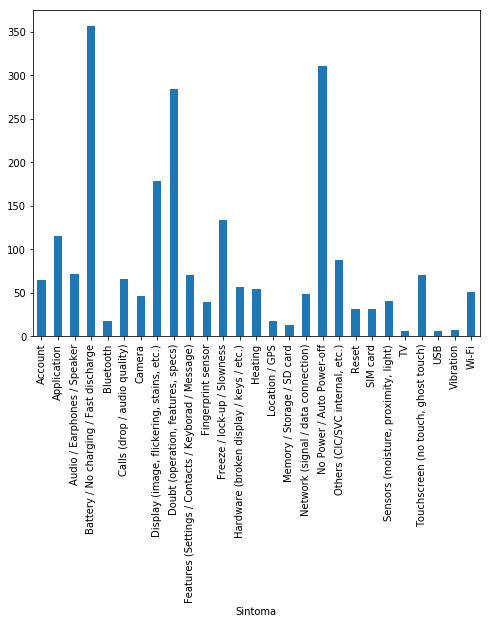

In [7]:
fig = plt.figure(figsize=(8,6))
df.groupby('Sintoma').Sintoma.count().plot.bar(ylim=0)
plt.show()

In [8]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords_cust = stopwords.words('portuguese')

df_swc = pd.read_excel('C:\Users\marcel.massa.LGE\ML\stop_words_customized.xlsx')
df_swc.STOP_WORDS_CUSTOMIZED=df_swc.STOP_WORDS_CUSTOMIZED.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
for count in range (df_swc.shape[0]):
    stopwords_cust.append(df_swc.STOP_WORDS_CUSTOMIZED[count])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), lowercase=True, stop_words=stopwords_cust, strip_accents='unicode')

features = tfidf.fit_transform(df.Texto).toarray()
labels = df.category_id
features.shape

(2272, 2525)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np

N = 5
for Sintoma, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Sintoma))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]).encode('utf-8')))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]).encode('utf-8')))

# 'Account':
  . Most correlated unigrams:
       . lembro
       . google
       . pedindo
       . conta
       . senha
  . Most correlated bigrams:
       . reset teclas
       . nao lembro
       . pedindo senha
       . conta google
       . senha nao
# 'Application':
  . Most correlated unigrams:
       . aplicativos
       . whatsapp
       . aplicativo
       . app
       . uber
  . Most correlated bigrams:
       . aplicativo whatsapp
       . informa aplicativo
       . uber driver
       . aplicativo uber
       . app uber
# 'Audio / Earphones / Speaker':
  . Most correlated unigrams:
       . auto
       . som
       . falante
       . ouvido
       . fone
  . Most correlated bigrams:
       . nao escuta
       . sai som
       . auto falante
       . alto falante
       . fone ouvido
# 'Battery / No charging / Fast discharge':
  . Most correlated unigrams:
       . carga
       . carregar
       . descarrega
       . rapido
       . carrega
  . Most correlated bigrams:
   

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    PassiveAggressiveClassifier(),
    ComplementNB(),
    DecisionTreeClassifier(random_state=0),
    SVC(kernel='linear'),
    KNeighborsClassifier(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.head()

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.663090
1,RandomForestClassifier,1,0.722707
2,RandomForestClassifier,2,0.701099
3,RandomForestClassifier,3,0.678571
4,RandomForestClassifier,4,0.640449


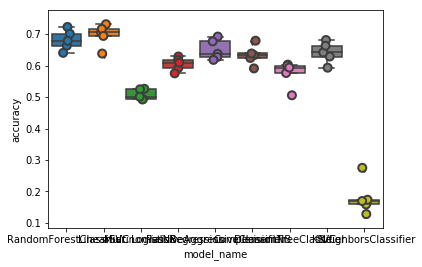

In [11]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
ComplementNB                   0.633133
DecisionTreeClassifier         0.575758
KNeighborsClassifier           0.181053
LinearSVC                      0.697266
LogisticRegression             0.604667
MultinomialNB                  0.507550
PassiveAggressiveClassifier    0.650322
RandomForestClassifier         0.681183
SVC                            0.641588
Name: accuracy, dtype: float64

In [27]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


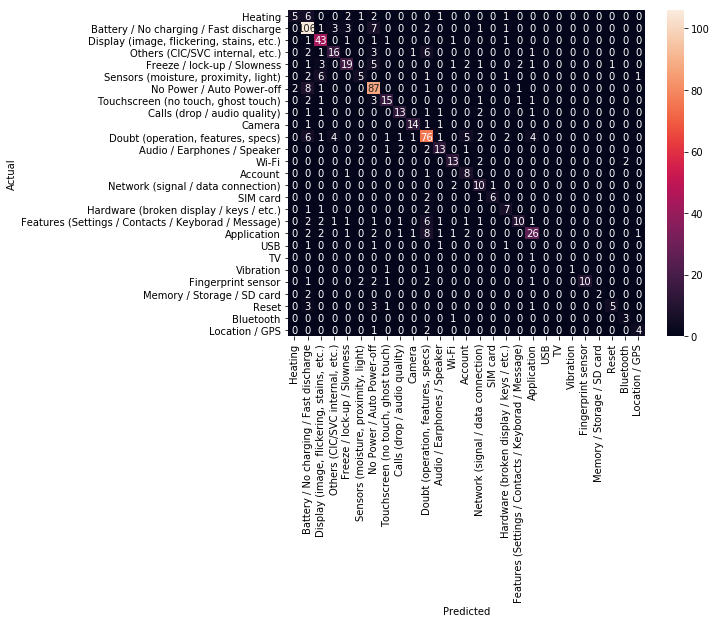

In [28]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Sintoma.values, yticklabels=category_id_df.Sintoma.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6893333333333334

In [30]:
category_id_df.Sintoma.values

array([u'Heating', u'Battery / No charging / Fast discharge',
       u'Display (image, flickering, stains, etc.)',
       u'Others (CIC/SVC internal, etc.)', u'Freeze / lock-up / Slowness',
       u'Sensors (moisture, proximity, light)',
       u'No Power / Auto Power-off',
       u'Touchscreen (no touch, ghost touch)',
       u'Calls (drop / audio quality)', u'Camera',
       u'Doubt (operation, features, specs)',
       u'Audio / Earphones / Speaker', u'Wi-Fi', u'Account',
       u'Network (signal / data connection)', u'SIM card',
       u'Hardware (broken display / keys / etc.)',
       u'Features (Settings / Contacts / Keyborad / Message)',
       u'Application', u'USB', u'TV', u'Vibration', u'Fingerprint sensor',
       u'Memory / Storage / SD card', u'Reset', u'Bluetooth',
       u'Location / GPS'], dtype=object)

In [31]:
from sklearn.metrics import classification_report

lista_sintomas = df['Sintoma'].drop_duplicates()

print(classification_report(y_test, y_pred, target_names=[u'Heating', u'Battery / No charging / Fast discharge',
       u'Display (image, flickering, stains, etc.)',
       u'Others (CIC/SVC internal, etc.)', u'Freeze / lock-up / Slowness',
       u'Sensors (moisture, proximity, light)',
       u'No Power / Auto Power-off',
       u'Touchscreen (no touch, ghost touch)',
       u'Calls (drop / audio quality)', u'Camera',
       u'Doubt (operation, features, specs)',
       u'Audio / Earphones / Speaker', u'Wi-Fi', u'Account',
       u'Network (signal / data connection)', u'SIM card',
       u'Hardware (broken display / keys / etc.)',
       u'Features (Settings / Contacts / Keyborad / Message)',
       u'Application', u'USB', u'TV', u'Vibration', u'Fingerprint sensor',
       u'Memory / Storage / SD card', u'Reset', u'Bluetooth',
       u'Location / GPS']))

                                                     precision    recall  f1-score   support

                                            Heating       0.71      0.28      0.40        18
             Battery / No charging / Fast discharge       0.72      0.85      0.78       124
          Display (image, flickering, stains, etc.)       0.68      0.88      0.77        49
                    Others (CIC/SVC internal, etc.)       0.67      0.53      0.59        30
                        Freeze / lock-up / Slowness       0.68      0.53      0.59        36
               Sensors (moisture, proximity, light)       0.50      0.31      0.38        16
                          No Power / Auto Power-off       0.74      0.87      0.80       100
                Touchscreen (no touch, ghost touch)       0.71      0.62      0.67        24
                       Calls (drop / audio quality)       0.72      0.65      0.68        20
                                             Camera       0.82      0

c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [140]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [141]:
from sklearn.feature_selection import chi2

N = 5
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams).encode('utf-8')))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams).encode('utf-8')))

# 'Account':
  . Top unigrams:
       . senha
       . conta
       . pede
       . bloqueou
       . pedindo
  . Top bigrams:
       . senha nao
       . deseja remover
       . conta google
       . reset teclas
       . procedimento reset
# 'Application':
  . Top unigrams:
       . uber
       . app
       . aplicativos
       . whatsapp
       . aplicativo
  . Top bigrams:
       . app uber
       . aplicativo uber
       . apresenta mensagem
       . apresenta falhas
       . caso nao
# 'Audio / Earphones / Speaker':
  . Top unigrams:
       . som
       . audio
       . microfone
       . saida
       . fone
  . Top bigrams:
       . nao sai
       . nao escuta
       . sai som
       . fone ouvido
       . alto falante
# 'Battery / No charging / Fast discharge':
  . Top unigrams:
       . rapido
       . carrega
       . descarregando
       . carregar
       . bateria
  . Top bigrams:
       . nao carrega
       . nao carregando
       . descarregando rapido
       . carregador

In [ ]:
texts = ["Se desligando quando esquenta",
         "Aparelho esta travado desde das 06:00 da manhã,  e fica iniciando com informação de iniciando e  após isso com a mensagem  que android esta iniciando e  que não desligue.  Orientada a forçar a inicialização do aparelho. Procedimento efetuado com sucesso.",
         "Cliente relata que seu aparelho não esta saindo nenhum som, totalmente mudo, só funciona no fone de ouvido, restauração persiste com o problema. ",
         "Cliente realizou reset de fábrica sem remover conta Google cadastrada.   **Informado que para ter acesso ao aparelho será necessário inserir conta existente anteriormente no produto**",
         "ligo o meu celular ele inicia , aparece o logo da e desliga sozinho.  **Orientada a conectar o aparelho no carregador** Cliente relata que o aparelho voltou a ligar e ele estava com 1% de bateria."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
df_new = pd.read_excel('C:\Users\marcel.massa.LGE\ML\CIC Call Receiving Rate.xls')
df_new.head()

In [97]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8669 entries, 0 to 8668
Data columns (total 21 columns):
Unnamed: 0                    0 non-null float64
Consultation No*              8669 non-null object
Receipt Day-YYYYMMDD          8669 non-null int64
dtypes: float64(1), int64(1), object(19)
memory usage: 778.9+ KB


In [99]:
df_new.columns

Index([u'Unnamed: 0', u'Receipt Day-YYYYMMDD'],
      dtype='object')

In [101]:
features_new = tfidf.transform(df_new.loc[: ,"Consultation Content"])
features_new.shape

(8669, 1621)

In [102]:
texts_new = df_new.loc[: ,"Consultation Content"]
text_features_new = tfidf.transform(texts_new)
predictions_new = model.predict(text_features_new)
#for text, predicted in zip(texts_new, predictions_new):
#  print(u'"{}"'.format(text))
#  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
#  print("")

In [ ]:
df_new['Sintoma'] = predictions_new
df_new.head()

In [ ]:
for count in range (df_new.shape[0]):
    df_new.Sintoma[count] = id_to_category[predictions_new[count]]
df_new.head()

In [106]:
df_new.to_excel('C:\Users\marcel.massa.LGE\ML\CIC Call Receiving Rate_PREDICTED.xlsx')